In [43]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import subprocess
import seaborn as sns
from sklearn.metrics import precision_recall_curve
from prg import prg

In [44]:
def get_target(col):
    return col.split('.')[1].split(':')[0]

def load_target(path, target):
    try:
        return pickle.load(open('{}/{}.pkl'.format(DSC_PATH, path), 'rb'))[target]
    except Exception:
        return []

def aggregate_columns(df, keyword):
    target_cols = df.columns[[keyword in c for c in df.columns]]
    fp = pd.concat([df.loc[:, c].dropna() for c in target_cols])
    df.loc[:, keyword] = fp
    df.drop(np.delete(target_cols, np.where(target_cols == keyword)), axis=1, inplace=True)
    return df

def load_output_columns(df):
    output_columns = df.columns[['output' in c for c in df.columns]]
    targets = np.unique([get_target(oc) for oc in output_columns])
    for t in targets:
        aggregate_columns(df, '{}:output'.format(t))
        df.loc[:, t] = df.loc[:, '{}:output'.format(t)].apply(lambda x: load_target(x, t))
        df.drop('{}:output'.format(t), axis=1, inplace=True)
    return df

### Query DSC

In [82]:
DSC_PATH = '../output/cafeh-simulations'


targets = [
    'normalize.normalize', 'fit_cafeh.model', 'fit_coloc.model', 'fit_ecaviar.model',
    'score_coloc_coloc.p_coloc',
    'score_coloc_cafeh.p_coloc',
    'score_coloc_ecaviar.p_coloc']

conditions = []


query_file = 'coloc.xlsx'

cmd_args = [
    'dsc-query', DSC_PATH,
    '-t', ' '.join(targets),
    '-o', query_file
]

subprocess.run('rm {}'.format(query_file), shell=True)
subprocess.run(' '.join(cmd_args), shell=True)

CompletedProcess(args='dsc-query ../output/cafeh-simulations -t normalize.normalize fit_cafeh.model fit_coloc.model fit_ecaviar.model score_coloc_coloc.p_coloc score_coloc_cafeh.p_coloc score_coloc_ecaviar.p_coloc -o coloc.xlsx', returncode=0)

In [54]:
cmd = ' '.join(cmd_args)
!{cmd}

INFO: Loading database ...
INFO: Running queries ...
Overwrite existing file "coloc.xlsx"? (y/n/a)? ^C
Traceback (most recent call last):
  File "/Users/karltayeb/anaconda3/envs/cafeh-sim-env/bin/dsc-query", line 8, in <module>
    sys.exit(main())
  File "/Users/karltayeb/anaconda3/envs/cafeh-sim-env/lib/python3.6/site-packages/dsc/__query__.py", line 268, in main
    args.func(args)
  File "/Users/karltayeb/anaconda3/envs/cafeh-sim-env/lib/python3.6/site-packages/dsc/__query__.py", line 125, in query
    fxlsx) and not am.get(f"Overwrite existing file \"{fxlsx}\"?"):
  File "/Users/karltayeb/anaconda3/envs/cafeh-sim-env/lib/python3.6/site-packages/sos/__main__.py", line 1822, in get
    res = input('{} (y/n/a)? '.format(msg))
KeyboardInterrupt


In [83]:
xls = pd.ExcelFile(query_file)
info = [xls.parse(x) for x in xls.sheet_names]
spec = pd.read_excel(xls, 'Sheet1')
aggregate_columns(spec, 'model')

,DSC,normalize.normalize,fit_cafeh,score_coloc_coloc.p_coloc:output,score_coloc_cafeh.p_coloc:output,score_coloc_ecaviar.p_coloc:output,model
0,1,True,NaN,NaN,NaN,score_coloc_ecaviar/small_genotype_1_general_s...,ecaviar
1,1,True,NaN,score_coloc_coloc/small_genotype_1_general_sim...,NaN,NaN,coloc
2,1,True,fit_cafeh_genotype,NaN,score_coloc_cafeh/small_genotype_1_general_sim...,NaN,cafeh_genotype
3,1,True,fit_cafeh_summary,NaN,score_coloc_cafeh/small_genotype_1_general_sim...,NaN,cafeh_summary
4,1,True,fit_cafeh_summary_simple,NaN,score_coloc_cafeh/small_genotype_1_general_sim...,NaN,cafeh_summary_simple


In [21]:
query = load_output_columns(spec)

In [22]:
query.rename(columns={c: c.replace('single_sim', 'simulations') for c in query.columns}, inplace=True)

In [26]:
query.loc[:, 'study_per_sim'] = query.true_effects.apply(lambda x: (x!=0).sum(0)[(x!=0).sum(0) > 0])

In [27]:
query

,DSC,fit_cafeh,simulations,simulations.pve,simulations.n_study,simulations.n_causal_per_study,model,p_coloc,true_coloc,true_effects,study_per_sim
0,1,NaN,general_sim,0.05,2,1,ecaviar,[1.0],[True],"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",[2]
1,1,NaN,general_sim,0.05,5,1,ecaviar,"[0.00016978642114800002, 0.0001697864211480000...","[False, False, True, False, True, True, True, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[2, 3]"
2,1,NaN,general_sim,0.05,10,1,ecaviar,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[True, True, True, False, False, False, True, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[3, 7]"
3,1,NaN,general_sim,0.05,2,2,ecaviar,[0.00029378578562],[False],"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1, 1, 1, 1]"
4,1,NaN,general_sim,0.05,5,2,ecaviar,"[0.0005307509708640001, 0.0005307509708640001,...","[True, True, True, True, True, False, True, Fa...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[3, 2, 3, 2]"
...,...,...,...,...,...,...,...,...,...,...,...
130,1,fit_cafeh_summary_simple,general_sim,0.20,5,2,cafeh_summary_simple,"[0.9999999999007242, 0.999999999900818, 0.9999...","[True, True, True, False, False, False, False,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1, 2, 2, 1, 3, 1]"
131,1,fit_cafeh_summary_simple,general_sim,0.20,10,2,cafeh_summary_simple,"[0.9999999999011876, 0.02792898589746695, 0.04...","[True, False, False, True, True, False, True, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[3, 5, 1, 4, 1, 4, 2]"
132,1,fit_cafeh_summary_simple,general_sim,0.20,2,3,cafeh_summary_simple,[0.046226240325177415],[True],"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1, 1, 1, 1, 2]"
133,1,fit_cafeh_summary_simple,general_sim,0.20,5,3,cafeh_summary_simple,"[0.9999999999011272, 0.05265424195532664, 0.07...","[True, False, False, False, True, True, False,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1, 1, 2, 3, 1, 1, 2, 2, 1, 1]"


### Make PR curves for pips

We can compare finemapping performance of SuSiE, CAVIAR, and CAFEH with (study, variant) PIPs
for SuSie and CAVIAR these are just the PIPs for each study concatenated
for CAFEH we can compute a study level pip: the posterior inclusion probability for a particular study

In [9]:
def make_pr_curve(df, label):
    labels = np.concatenate([x.flatten() != 0 for x in df.true_effects.values])
    pred = np.concatenate([x.flatten() for x in df.study_pip.values])

    p, r, t = precision_recall_curve(labels, pred)
    plt.plot(r, p, label=label)

In [10]:
def make_prg_curve(df, label):
    labels = np.concatenate([x.flatten() != 0 for x in df.true_effects.values])
    pred = np.concatenate([x.flatten() for x in df.study_pip.values])
    prg_curve = prg.create_prg_curve(labels, pred)
    p, r = prg_curve['precision_gain'], prg_curve['recall_gain']
    plt.plot(p, r, label=label)

In [11]:
def _plot_pr(X, Y, **kwargs):
    labels = np.concatenate([x.flatten() != 0 for x in X])
    pred = np.concatenate([y.flatten() for y in Y])

    p, r, _ = precision_recall_curve(labels, pred)
    plt.plot(r, p, **kwargs)
    
def _plot_prg(X, Y, **kwargs):
    labels = np.concatenate([x.flatten() != 0 for x in X])
    pred = np.concatenate([y.flatten() for y in Y])
    prg_curve = prg.create_prg_curve(labels, pred)
    p, r = prg_curve['precision_gain'], prg_curve['recall_gain']
    plt.plot(r, p, **kwargs)    

In [12]:
query.model.unique()

array(['ecaviar', 'coloc', 'cafeh_genotype', 'cafeh_summary',
       'cafeh_summary_simple'], dtype=object)

In [18]:
query

,DSC,fit_cafeh,simulations,simulations.pve,simulations.n_study,simulations.n_causal_per_study,model,p_coloc,true_coloc
0,1,NaN,general_sim,0.05,2,1,ecaviar,[1.0],[True]
1,1,NaN,general_sim,0.05,5,1,ecaviar,"[0.00016978642114800002, 0.0001697864211480000...","[False, False, True, False, True, True, True, ..."
2,1,NaN,general_sim,0.05,10,1,ecaviar,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[True, True, True, False, False, False, True, ..."
3,1,NaN,general_sim,0.05,2,2,ecaviar,[0.00029378578562],[False]
4,1,NaN,general_sim,0.05,5,2,ecaviar,"[0.0005307509708640001, 0.0005307509708640001,...","[True, True, True, True, True, False, True, Fa..."
...,...,...,...,...,...,...,...,...,...
130,1,fit_cafeh_summary_simple,general_sim,0.20,5,2,cafeh_summary_simple,"[0.9999999999007242, 0.999999999900818, 0.9999...","[True, True, True, False, False, False, False,..."
131,1,fit_cafeh_summary_simple,general_sim,0.20,10,2,cafeh_summary_simple,"[0.9999999999011876, 0.02792898589746695, 0.04...","[True, False, False, True, True, False, True, ..."
132,1,fit_cafeh_summary_simple,general_sim,0.20,2,3,cafeh_summary_simple,[0.046226240325177415],[True]
133,1,fit_cafeh_summary_simple,general_sim,0.20,5,3,cafeh_summary_simple,"[0.9999999999011272, 0.05265424195532664, 0.07...","[True, False, False, False, True, True, False,..."


In [13]:
query.columns

Index(['DSC', 'fit_cafeh', 'simulations', 'simulations.pve',
       'simulations.n_study', 'simulations.n_causal_per_study', 'model',
       'p_coloc', 'true_coloc'],
      dtype='object')

### Precision recall curves

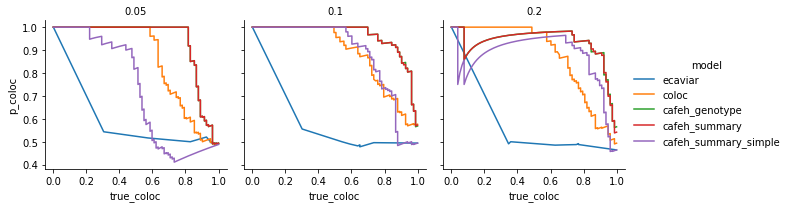

In [15]:
models = query.model.unique()
#models = ['susie_genotype', 'susie_genotype_ss', 'cafeh_genotype', 'CAVIAR']
df = query[query.model.isin(models)]
g = sns.FacetGrid(df, hue='model', col='simulations.pve')
g.map(_plot_pr, 'true_coloc', 'p_coloc')
g.add_legend()
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

### Precision Recall Gain Curves

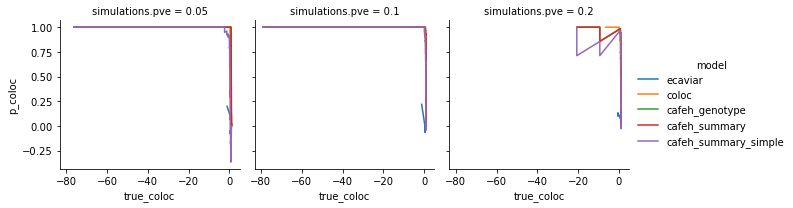

In [17]:
#models = ['susie_genotype', 'susie_genotype_ss', 'cafeh_genotype', 'CAVIAR']
df = query
g = sns.FacetGrid(df, hue='model', col='simulations.pve')
g.map(_plot_prg, 'true_coloc', 'p_coloc')
g.add_legend();

In [3]:
import numpy as np

valid_snps = np.arange(100)
for t in range(10):
    causal_snps = np.random.choice(valid_snps, 5)
    valid_snps = np.delete(valid_snps, causal_snps)

In [28]:
query.columns

Index(['DSC', 'fit_cafeh', 'simulations', 'simulations.pve',
       'simulations.n_study', 'simulations.n_causal_per_study', 'model',
       'p_coloc', 'true_coloc', 'true_effects', 'study_per_sim'],
      dtype='object')

In [33]:
tp = lambda x: (x.true_coloc & (x.p_coloc > 0.5)).sum()
fp = lambda x: (~x.true_coloc & (x.p_coloc > 0.5)).sum()
tn = lambda x: (~x.true_coloc & ~(x.p_coloc > 0.5)).sum()
fn = lambda x: (x.true_coloc & ~(x.p_coloc > 0.5)).sum()

In [34]:
query.loc[:, 'TP'] = query.apply(tp, axis=1)
query.loc[:, 'FP'] = query.apply(fp, axis=1)
query.loc[:, 'TN'] = query.apply(tn, axis=1)
query.loc[:, 'FN'] = query.apply(fn, axis=1)

In [35]:
query

,DSC,fit_cafeh,simulations,simulations.pve,simulations.n_study,simulations.n_causal_per_study,model,p_coloc,true_coloc,true_effects,study_per_sim,TP,FP,TN,FN
0,1,NaN,general_sim,0.05,2,1,ecaviar,[1.0],[True],"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",[2],1,0,0,0
1,1,NaN,general_sim,0.05,5,1,ecaviar,"[0.00016978642114800002, 0.0001697864211480000...","[False, False, True, False, True, True, True, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[2, 3]",0,0,6,4
2,1,NaN,general_sim,0.05,10,1,ecaviar,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[True, True, True, False, False, False, True, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[3, 7]",24,21,0,0
3,1,NaN,general_sim,0.05,2,2,ecaviar,[0.00029378578562],[False],"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1, 1, 1, 1]",0,0,1,0
4,1,NaN,general_sim,0.05,5,2,ecaviar,"[0.0005307509708640001, 0.0005307509708640001,...","[True, True, True, True, True, False, True, Fa...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[3, 2, 3, 2]",0,0,2,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,1,fit_cafeh_summary_simple,general_sim,0.20,5,2,cafeh_summary_simple,"[0.9999999999007242, 0.999999999900818, 0.9999...","[True, True, True, False, False, False, False,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1, 2, 2, 1, 3, 1]",3,0,5,2
131,1,fit_cafeh_summary_simple,general_sim,0.20,10,2,cafeh_summary_simple,"[0.9999999999011876, 0.02792898589746695, 0.04...","[True, False, False, True, True, False, True, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[3, 5, 1, 4, 1, 4, 2]",20,0,22,3
132,1,fit_cafeh_summary_simple,general_sim,0.20,2,3,cafeh_summary_simple,[0.046226240325177415],[True],"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1, 1, 1, 1, 2]",0,0,0,1
133,1,fit_cafeh_summary_simple,general_sim,0.20,5,3,cafeh_summary_simple,"[0.9999999999011272, 0.05265424195532664, 0.07...","[True, False, False, False, True, True, False,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1, 1, 2, 3, 1, 1, 2, 2, 1, 1]",2,1,4,3


In [5]:
valid_snps = np.arange(100)
causal_snps = np.arange(10)

In [6]:
np.delete(valid_snps, causal_snps)

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94,
       95, 96, 97, 98, 99])